# 🎯 Milestone 1: Data Collection, Exploration, and Preprocessing  

📌 Section 1: Setup & Mount Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio matplotlib  scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.1 MB/s eta 0:00:00


In [3]:
import os
import cv2
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

📌 Section 2: Define Paths & Dataset Parameters

In [9]:
final_dataset_path = "/content/drive/My Drive/EuroSAT_Final_Dataset"
os.makedirs(final_dataset_path, exist_ok=True)

In [19]:
dataset_path = "https://zenodo.org/records/7711810/files/EuroSAT_MS.zip?download=1"
Data_path='/content/drive/My Drive/DEPI/Data/Original_Data'
import zipfile
import requests

def download_eurosat_rgb(destination=Data_path):
    os.makedirs(destination, exist_ok=True)
    url = dataset_path
    zip_path = os.path.join(destination, 'EuroSAT_RGB.zip')

    print("[INFO] Downloading EuroSAT RGB dataset...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(zip_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    print("[INFO] Extracting ZIP file...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination)

    os.remove(zip_path)
    print("[INFO] Dataset ready at:", destination)

In [20]:
download_eurosat_rgb()

[INFO] Downloading EuroSAT RGB dataset...
[INFO] Extracting ZIP file...
[INFO] Dataset ready at: /content/drive/My Drive/DEPI/Data/Original_Data


In [53]:


IMAGE_SIZE = (64, 64)

#  B02—Blue -> index 1 as it began with 0
#  B03—Green -> index 2 as it began with 0
#  B04—Red -> index 3 as it began with 0
#  B08—NIR -> index 7 as it began with 0

BANDS = [1, 2, 3, 7]

TARGET_COUNT = 4000


Get a sample image to check available bands

In [22]:
sample_image_path = None

for root, dirs, files in os.walk(Data_path):
    for file in files:
        if file.endswith(".tif"):
            sample_image_path = os.path.join(root, file)
            break
    if sample_image_path:
        break

if sample_image_path:
    with rasterio.open(sample_image_path) as src:
        num_bands = src.count
        print(f"Sample Image: {sample_image_path}")
        print(f" Number of Spectral Bands: {num_bands}")
else:
    print("No images found in the dataset!")

Sample Image: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/Forest/Forest_2230.tif
 Number of Spectral Bands: 13


Load & Display an Image ✅ Load a sample image and check its properties.

In [37]:
print(os.listdir(Data_path))

['EuroSAT_MS']


In [38]:
Data_path='/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/'

In [39]:
print(os.listdir(Data_path))

['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']


In [40]:
selected_images = {}

# Go to land type folders and pick one image
for land_type in os.listdir(Data_path):
    land_type_path = os.path.join(Data_path, land_type)
    print(land_type_path)
    if os.path.isdir(land_type_path):
        for filename in os.listdir(land_type_path):
            if filename.endswith(".tif"):
                selected_images[land_type] = os.path.join(land_type_path, filename)
                print(selected_images[land_type])
                break

for land_type, image_path in selected_images.items():
    print(f"✅ Selected {land_type}: {image_path}")


example_land_type = list(selected_images.keys())[0]
example_image_path = selected_images[example_land_type]

with rasterio.open(example_image_path) as src:
    image = src.read()

print(f"✅ Loaded {example_land_type} image with shape: {image.shape}")


/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/Forest
/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/Forest/Forest_2230.tif
/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/River
/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/River/River_1817.tif
/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/Highway
/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/Highway/Highway_1320.tif
/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/AnnualCrop
/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/AnnualCrop/AnnualCrop_1855.tif
/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/SeaLake
/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/SeaLake/SeaLake_1126.tif
/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/HerbaceousVegetation
/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/HerbaceousVegetation/HerbaceousVegetation_921.tif
/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_

Visualize Spectral Bands ✅ Display individual bands (e.g., RGB & Near-Infrared) for analysis.

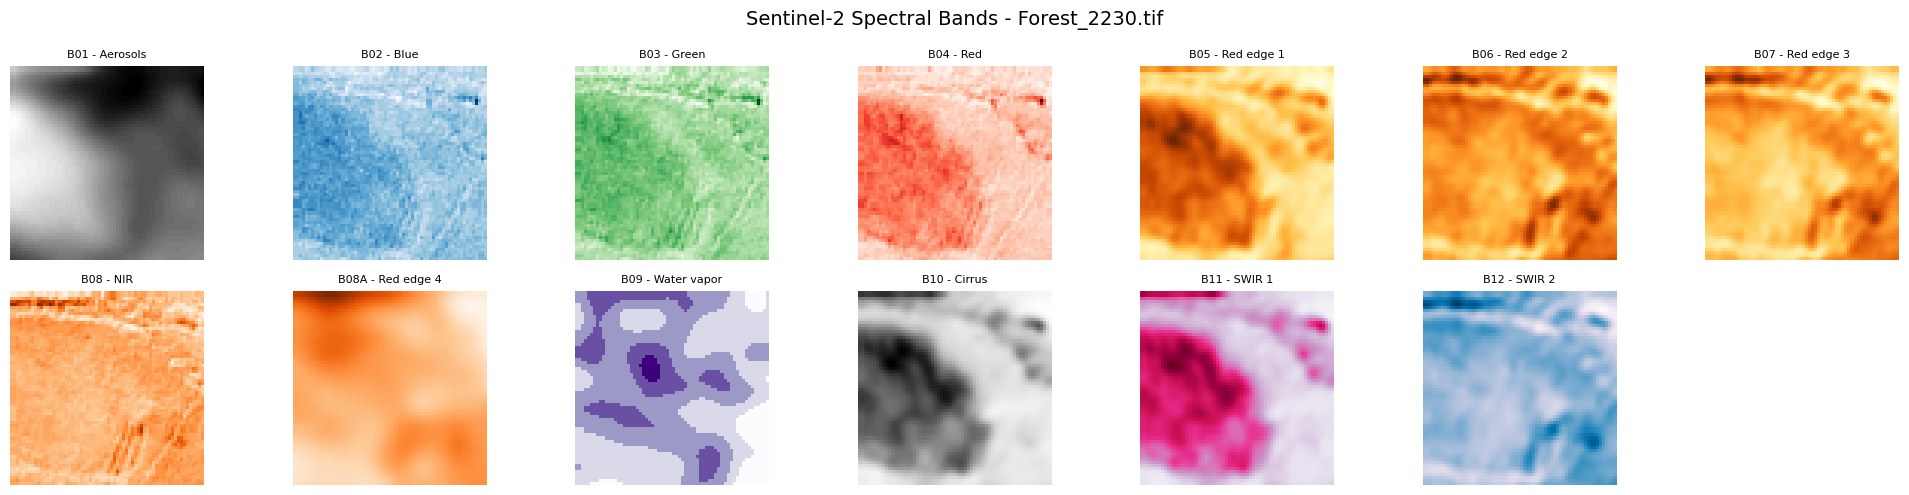

In [47]:

# Sentinel-2 band names
BAND_LABELS = [
    "B01 - Aerosols",
    "B02 - Blue",
    "B03 - Green",
    "B04 - Red",
    "B05 - Red edge 1",
    "B06 - Red edge 2",
    "B07 - Red edge 3",
    "B08 - NIR",
    "B08A - Red edge 4",
    "B09 - Water vapor",
    "B10 - Cirrus",
    "B11 - SWIR 1",
    "B12 - SWIR 2"
]

# Colormap per band based on wavelength
BAND_COLORS = [
    'gray',     # B01 - Aerosols
    'Blues',    # B02 - Blue
    'Greens',   # B03 - Green
    'Reds',     # B04 - Red
    'YlOrBr',   # B05 - Red edge 1
    'YlOrBr',   # B06 - Red edge 2
    'YlOrBr',   # B07 - Red edge 3
    'Oranges',  # B08 - NIR
    'Oranges',  # B08A - Red edge 4
    'Purples',  # B09 - Water vapor
    'Greys',    # B10 - Cirrus
    'PuRd',     # B11 - SWIR 1
    'PuBu',     # B12 - SWIR 2
]

def plot_bands(image, filename):
    num_bands = image.shape[0]
    plt.figure(figsize=(20, 5))
    for i in range(num_bands):
        plt.subplot(2, (num_bands + 1) // 2, i + 1)

        band = image[i].astype(np.float32)
        band = (band - band.min()) / (band.max() - band.min() + 1e-6)

        cmap = BAND_COLORS[i] if i < len(BAND_COLORS) else 'gray'
        label = BAND_LABELS[i] if i < len(BAND_LABELS) else f"Band {i + 1}"

        plt.imshow(band, cmap=cmap)
        plt.title(label, fontsize=8)
        plt.axis("off")

    plt.suptitle(f"Sentinel-2 Spectral Bands - {filename}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Example usage
plot_bands(image, os.path.basename(example_image_path))


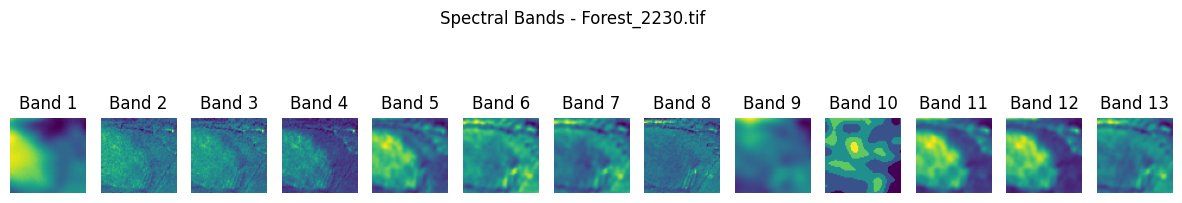

In [48]:
def plot_bands(image, filename):
    plt.figure(figsize=(15, 3))
    for i in range(image.shape[0]):
        plt.subplot(1, image.shape[0], i+1)
        plt.imshow(image[i])
        plt.title(f"Band {i+1}")
        plt.axis("off")
    plt.suptitle(f"Spectral Bands - {filename}")
    plt.show()

plot_bands(image, os.path.basename(example_image_path))


Display the no. of imgs per each category

<ipython-input-50-7bc3a40f60a8>:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


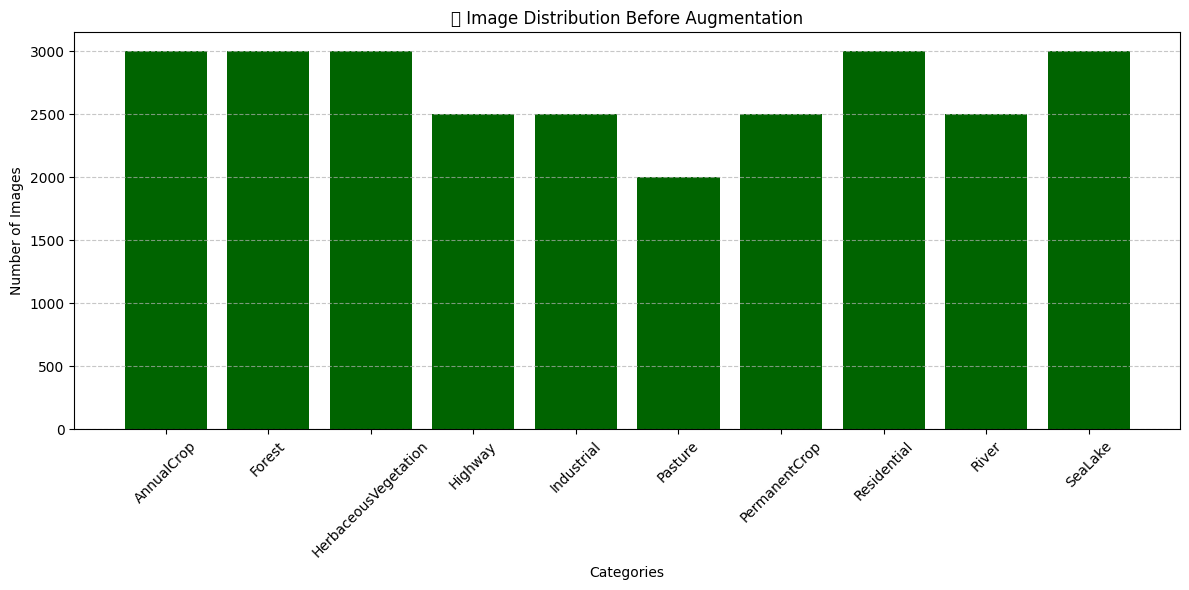

In [50]:
#  Count Images  (Before Augmentation)
categories = sorted(os.listdir(Data_path))
category_counts = {}

for category in categories:
    category_folder = os.path.join(Data_path, category)
    if os.path.isdir(category_folder):
        category_counts[category] = len([file for file in os.listdir(category_folder) if file.endswith(".tif")])


category_names = list(category_counts.keys())
image_counts = list(category_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(category_names, image_counts, color="darkgreen")
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("📊 Image Distribution Before Augmentation")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


📌 Section 3: Define Image Processing & Augmentation

In [61]:
#  Define Image Processing Function
def process_tiff_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read(BANDS).astype(np.float32)
        image = np.transpose(image, (1, 2, 0))  # Convert (C, H, W) → (H, W, C)
        image = cv2.resize(image, IMAGE_SIZE)

        # Proper normalization
        image = (image - image.min()) / (image.max() - image.min())

        # Apply gamma correction
        # gamma = 2.2
        # image = np.power(image, 1 / gamma)

        # Convert to 8-bit for visualization
        # image = (image * 255).astype(np.uint8)



    return image


#  Define Augmentation
# augmentation = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=1.0),
#     A.RandomBrightnessContrast(p=0.2),
#     A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),  # Normalize correctly
# ])


Test the Processing & Augmentation

The Img Shape = (64, 64, 3)


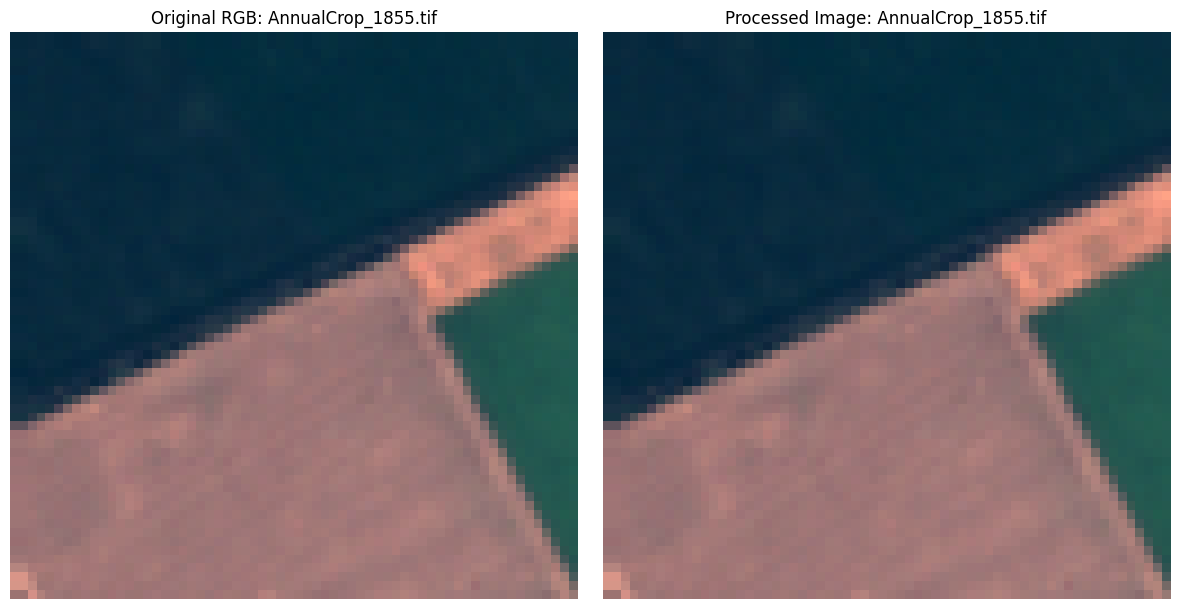

In [82]:

# Define path to sample
BANDS = [4, 3, 2]  # Sentinel-2: Red, Green, Blue (1-based indexing)

sample_category = sorted(os.listdir(Data_path))[0]
sample_path = os.path.join(Data_path, sample_category)

# Pick the first .tif file
sample_file = next(f for f in os.listdir(sample_path) if f.lower().endswith(".tif"))
sample_image_path = os.path.join(sample_path, sample_file)

# Read original RGB image
with rasterio.open(sample_image_path) as src:
    original_image = src.read(BANDS).astype(np.float32)  # shape: (3, H, W)
    original_image = np.transpose(original_image, (1, 2, 0))  # shape: (H, W, 3)
    original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

# Assume you already defined your `process_tiff_image` function
processed_image = process_tiff_image(sample_image_path)
print(f'The Img Shape = {processed_image.shape}')

# Plotting the true color image (original vs processed)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis("off")
plt.title(f"Original RGB: {sample_file}")

plt.subplot(1, 2, 2)
plt.imshow(processed_image[:, :, :3])
plt.axis("off")
plt.title(f"Processed Image: {sample_file}")

plt.tight_layout()
plt.show()


In [76]:
# Apply augmentation
augmented = augmentation(image=processed_image)["image"]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(processed_image[:, :, :3])
plt.axis("off")
plt.title(f"Processed Image: {sample_file}")
plt.subplot(1, 2, 2)
plt.imshow(augmented[:, :, :3])
plt.axis("off")
plt.title(f"Augmented Image: {sample_file}")
plt.show()

NameError: name 'augmentation' is not defined

📌 Section 4: Load, Process & Augment Images

In [ ]:
X, y = [], []
category_counts = {}

print("🔄 Processing TIFF Images from EuroSAT...")
for category in tqdm(sorted(os.listdir(dataset_path))):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):
        images = []
        for file in os.listdir(category_path):
            if file.lower().endswith(".tif"):
                image_path = os.path.join(category_path, file)
                img = process_tiff_image(image_path)
                if img is not None:
                    images.append(img)
                    X.append(img)
                    y.append(category)

        #  Apply Augmentation Until Each Category Has 4,000 Images
        current_count = len(images)
        category_counts[category] = current_count
        print(f"📊 Found {current_count} images in {category}.")

        if current_count < TARGET_COUNT:
            i = 0
            while current_count < TARGET_COUNT:
                image = images[i % len(images)]
                augmented = augmentation(image=image)
                X.append(augmented["image"])
                y.append(category)

                current_count += 1
                i += 1

            print(f"✅ Augmented {category} to {TARGET_COUNT} images!")


X = np.array(X) # <------ Why .npy ? ---------> As it's faster to be called at modelling
y = np.array(y)

print(f"\n✅ Total Processed Images: {X.shape[0]}")


🔄 Processing TIFF Images from EuroSAT...


 10%|█         | 1/10 [04:02<36:25, 242.88s/it]

📊 Found 3010 images in AnnualCrop.
✅ Augmented AnnualCrop to 4000 images!


 20%|██        | 2/10 [08:57<36:26, 273.28s/it]

📊 Found 3010 images in Forest.
✅ Augmented Forest to 4000 images!


 30%|███       | 3/10 [14:07<33:51, 290.19s/it]

📊 Found 3000 images in HerbaceousVegetation.
✅ Augmented HerbaceousVegetation to 4000 images!
📊 Found 2500 images in Highway.


 40%|████      | 4/10 [17:09<24:45, 247.51s/it]

✅ Augmented Highway to 4000 images!
📊 Found 2510 images in Industrial.


 50%|█████     | 5/10 [20:52<19:52, 238.44s/it]

✅ Augmented Industrial to 4000 images!
📊 Found 2000 images in Pasture.


 60%|██████    | 6/10 [22:44<13:02, 195.58s/it]

✅ Augmented Pasture to 4000 images!
📊 Found 2500 images in PermanentCrop.


 70%|███████   | 7/10 [25:39<09:26, 188.69s/it]

✅ Augmented PermanentCrop to 4000 images!


 80%|████████  | 8/10 [31:05<07:44, 232.38s/it]

📊 Found 3000 images in Residential.
✅ Augmented Residential to 4000 images!
📊 Found 2500 images in River.


 90%|█████████ | 9/10 [33:58<03:33, 213.86s/it]

✅ Augmented River to 4000 images!


100%|██████████| 10/10 [39:18<00:00, 235.86s/it]

📊 Found 3000 images in SeaLake.
✅ Augmented SeaLake to 4000 images!



✅ Total Processed Images: 40000


Save to be safe from any reprocessing

In [ ]:
#  Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("\n📜 Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

#  Save the Final Dataset
np.save(os.path.join(final_dataset_path, "X.npy"), X)
np.save(os.path.join(final_dataset_path, "y.npy"), y_encoded)

print("\n✅ Final Dataset Saved Successfully!")
print(f"📂 X.npy (images), y.npy (labels), and NDVI.npy are stored in: {final_dataset_path}")



📜 Label Mapping: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}

✅ Final Dataset Saved Successfully!
📂 X.npy (images), y.npy (labels), and NDVI.npy are stored in: /content/drive/My Drive/EuroSAT_Final_Dataset


Image Distribution After Augmentation

<ipython-input-13-95ab659ea815>:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


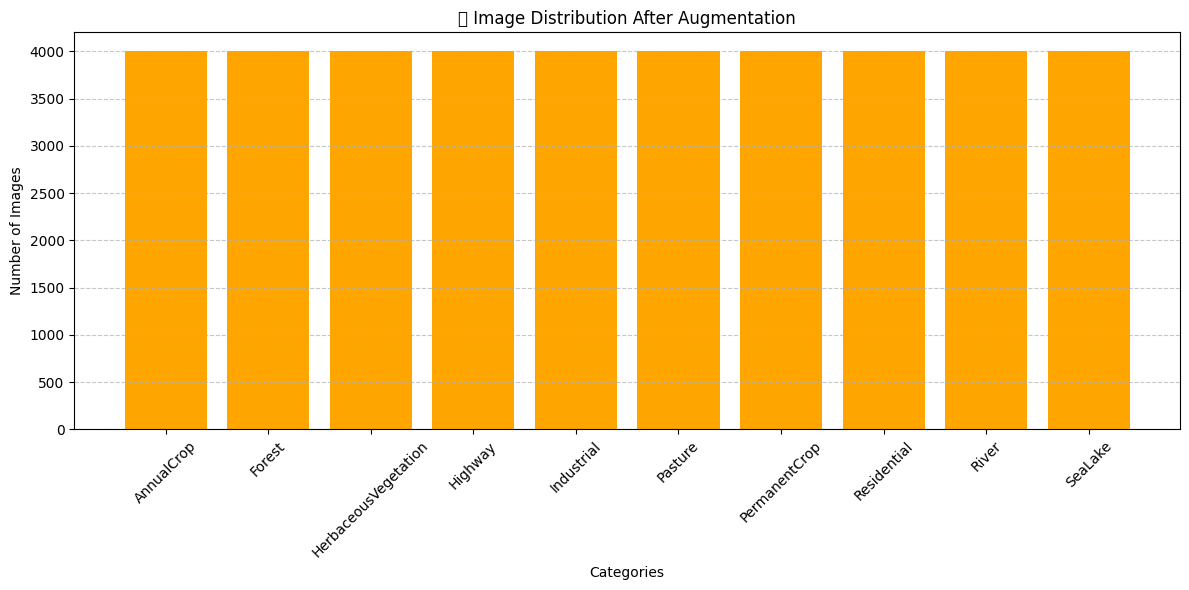

In [ ]:
#  Count Images After Augmentation
augmented_category_counts = Counter(y)

category_names = sorted(augmented_category_counts.keys())
image_counts = [augmented_category_counts[cat] for cat in category_names]

plt.figure(figsize=(12, 6))
plt.bar(category_names, image_counts, color="orange")
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("📊 Image Distribution After Augmentation")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

📌 Section 5: Compute NDVI for one Image

✅ Loaded X.shape: (40000, 64, 64, 4), y.shape: (40000,)

✅ NDVI Computation Completed!
📂 NDVI shape: (40000, 64, 64)

✅ Selected 10 categories for visualization.


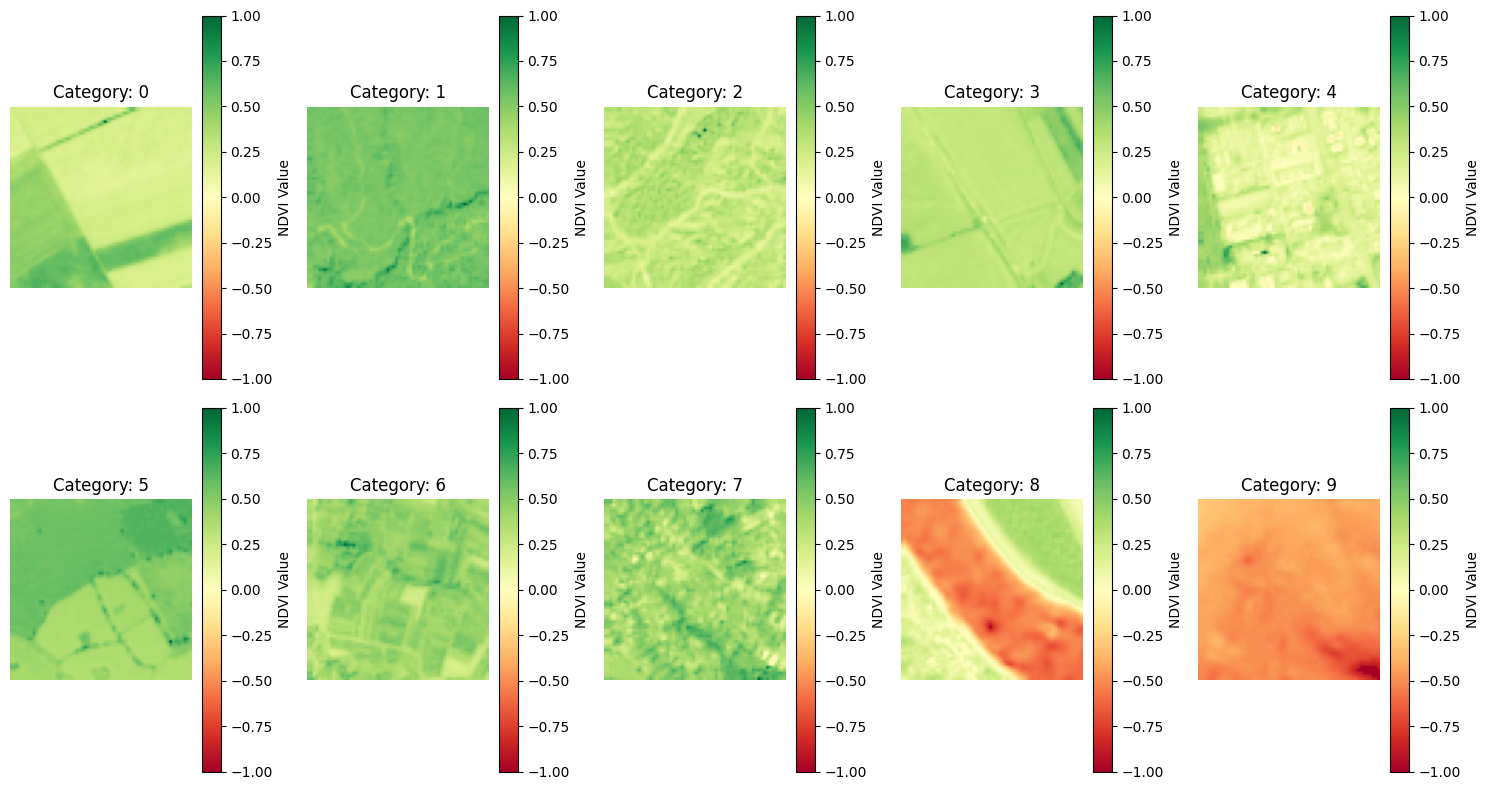

In [ ]:

X = np.load("/content/drive/My Drive/EuroSAT_Final_Dataset/X.npy", mmap_mode='r')
y = np.load("/content/drive/My Drive/EuroSAT_Final_Dataset/y.npy", mmap_mode='r')

print(f"✅ Loaded X.shape: {X.shape}, y.shape: {y.shape}")

#  Define NDVI
def compute_ndvi(image, nir_band=3, red_band=2):  # Computes NDVI using Near-Infrared (B8) and Red (B4) bands.
    nir = image[:, :, nir_band].astype(float)
    red = image[:, :, red_band].astype(float)
    ndvi = (nir - red) / (nir + red + 1e-5)
    return ndvi


ndvi_maps = np.array([compute_ndvi(img) for img in X])

print("\n✅ NDVI Computation Completed!")
print(f"📂 NDVI shape: {ndvi_maps.shape}")

#  Select One Image Per Category for Visualization
category_samples = {}

for idx, label in enumerate(y):
    if label not in category_samples:
        category_samples[label] = ndvi_maps[idx]


print(f"\n✅ Selected {len(category_samples)} categories for visualization.")


plt.figure(figsize=(15, 8))
for i, (category, ndvi_map) in enumerate(category_samples.items()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(ndvi_map, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label="NDVI Value")
    plt.title(f"Category: {category}")
    plt.axis("off")

plt.tight_layout()
plt.show()


📌 Section 6: Encode Labels & Save Final Dataset

In [ ]:
np.save(os.path.join(final_dataset_path, "NDVI.npy"), ndvi_maps)

print(f"Final Dataset Shape: NDVI={ndvi_maps.shape}")

Final Dataset Shape: NDVI=(40000, 64, 64)


# **🚀 Conclusion**
This notebook successfully:
- ✅ Validated dataset integrity
- ✅ Checked image quality & distributions
- ✅ Confirmed the presence of **multispectral bands**
- ✅ Displayed sample images from different categories
- ✅ Preprocessed images (resize, normalize, augment)
- ✅ Computed & visualized NDVI for vegetation analysis

Next Steps:
- **EDA** for land classification